In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['',
 'the last of the horse guards a huge pockmarked fellow frowned angrily',
 'dolokhov climbed carefully and slowly through the window and lowered his',
 'the divine mercy is inexhaustible unction is about to be administered',
 'matters social interests and the fair sex occupied no small part of his',
 'sitting in a conspicuous place and talking to him like a grownup lady',
 'with distinction and special marks of favor explaining to him that',
 'carriage at full speed about an hour before along that very road and',
 'my mother my mother my angel my adored angel mother and dolokhov',
 'i had not the pleasure of seeing you said prince andrew coldly and']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.8366,  0.5521, -1.6112,  ...,  0.6079, -1.3179, -0.1984],
        [ 1.8098,  0.6056,  1.5040,  ...,  0.5033,  0.1913, -0.5995],
        [ 0.4615, -1.3213,  2.1938,  ..., -1.0442, -0.4652,  0.0625],
        ...,
        [ 0.2519,  0.5107,  0.6830,  ...,  1.2300, -1.0387,  0.2203],
        [ 0.9122, -0.1668, -0.1227,  ...,  0.9946, -1.0291,  0.4550],
        [-0.5864,  1.2408,  1.5488,  ...,  0.2290,  2.0116, -0.5652]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/1837562056.py line 8 
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 15:07:18.708000 136147316295488 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 flanking dismissal tomorrow fiercely drubetskoy lolled shyly contradictory lording gascons conscripts announcing salt recovered liebchen thanked poured decidedly energetically oftrepeated say bearers himwould strained stand sleigh classically crushed eyelids killing pastime subordinate vight refrain came mortemart obedient legends vicomtes printed friend peppered selfsacrifice successful flush rivers warm feeblelooking saintsday robbery rye malgre leathergloved remarking frighten linen grant knocked motley soles asked strategically strained dragged haugwitz negotiations somber benefits chaos zakhar dwown learned wifethose saber moan dream additional abroad gentlemanevidently gentle guests herein putting barrier densely parts significance counseled opponent swarmed moan congratulated arrangingat misdirected waver friends now heiresses bushes unavoidable
 seeks enjoy expiate government marshal library equipment vicomtei opposite somberly member kinder subdued quarters shells detained st

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

len(stoi)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([1024, 512])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


11189

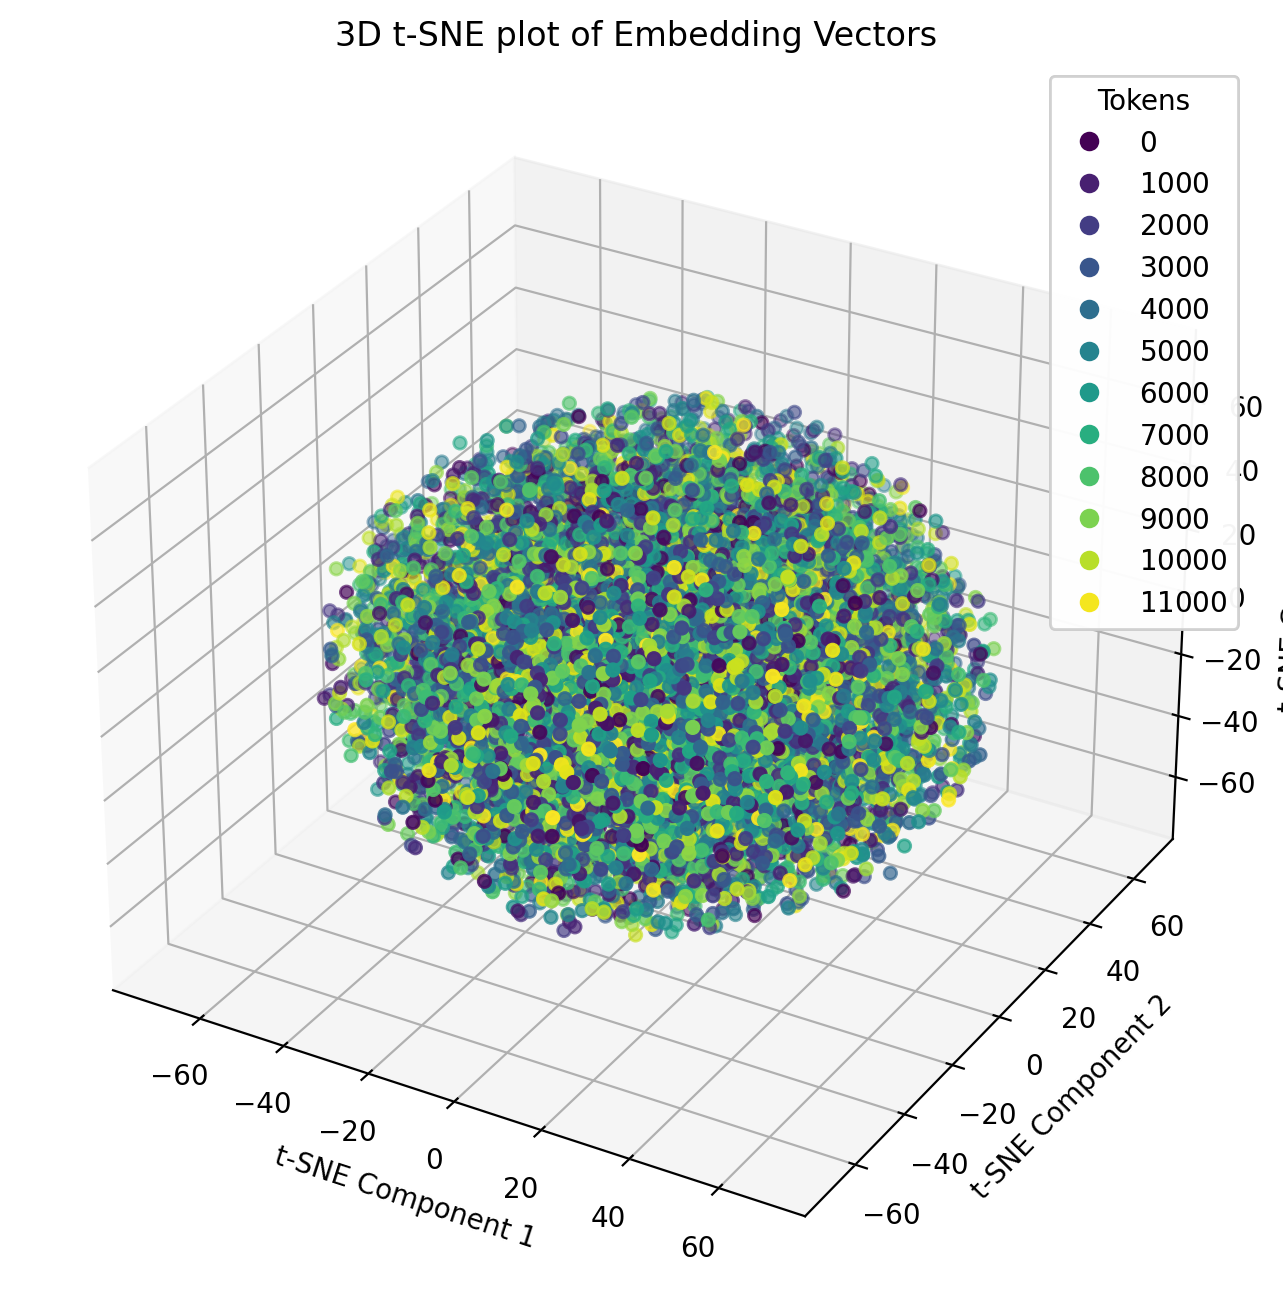

In [15]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [16]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass

Epoch 0, Loss: 12.657106399536133
Epoch 10, Loss: 10.096664428710938
Epoch 20, Loss: 9.09104061126709
Epoch 30, Loss: 8.250423431396484
Epoch 40, Loss: 7.49009895324707
Epoch 50, Loss: 6.810272216796875
Epoch 60, Loss: 6.263955116271973
Epoch 70, Loss: 5.877021312713623
Epoch 80, Loss: 5.598875999450684
Epoch 90, Loss: 5.383188724517822
Epoch 100, Loss: 5.205521583557129
Epoch 110, Loss: 5.05334997177124
Epoch 120, Loss: 4.918333530426025
Epoch 130, Loss: 4.795349597930908
Epoch 140, Loss: 4.680716514587402
Epoch 150, Loss: 4.572040557861328
Epoch 160, Loss: 4.46811580657959
Epoch 170, Loss: 4.36855411529541
Epoch 180, Loss: 4.273195266723633
Epoch 190, Loss: 4.181938171386719
Epoch 200, Loss: 4.094814300537109
Epoch 210, Loss: 4.011782646179199
Epoch 220, Loss: 3.932766914367676
Epoch 230, Loss: 3.857442855834961
Epoch 240, Loss: 3.7857728004455566
Epoch 250, Loss: 3.7173585891723633
Epoch 260, Loss: 3.652301549911499
Epoch 270, Loss: 3.590195894241333
Epoch 280, Loss: 3.5309398174285

In [17]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 
 get glasses behind on his artillery on soldiers
 
 
 
 subject he shouted to the cook from his hand
 well my only all my interests i must
 most usual in a paleblue on that her the eldest
 appeared to be opened he seeing him effect
 movements of the semenov blows if he had did not want to at himself he


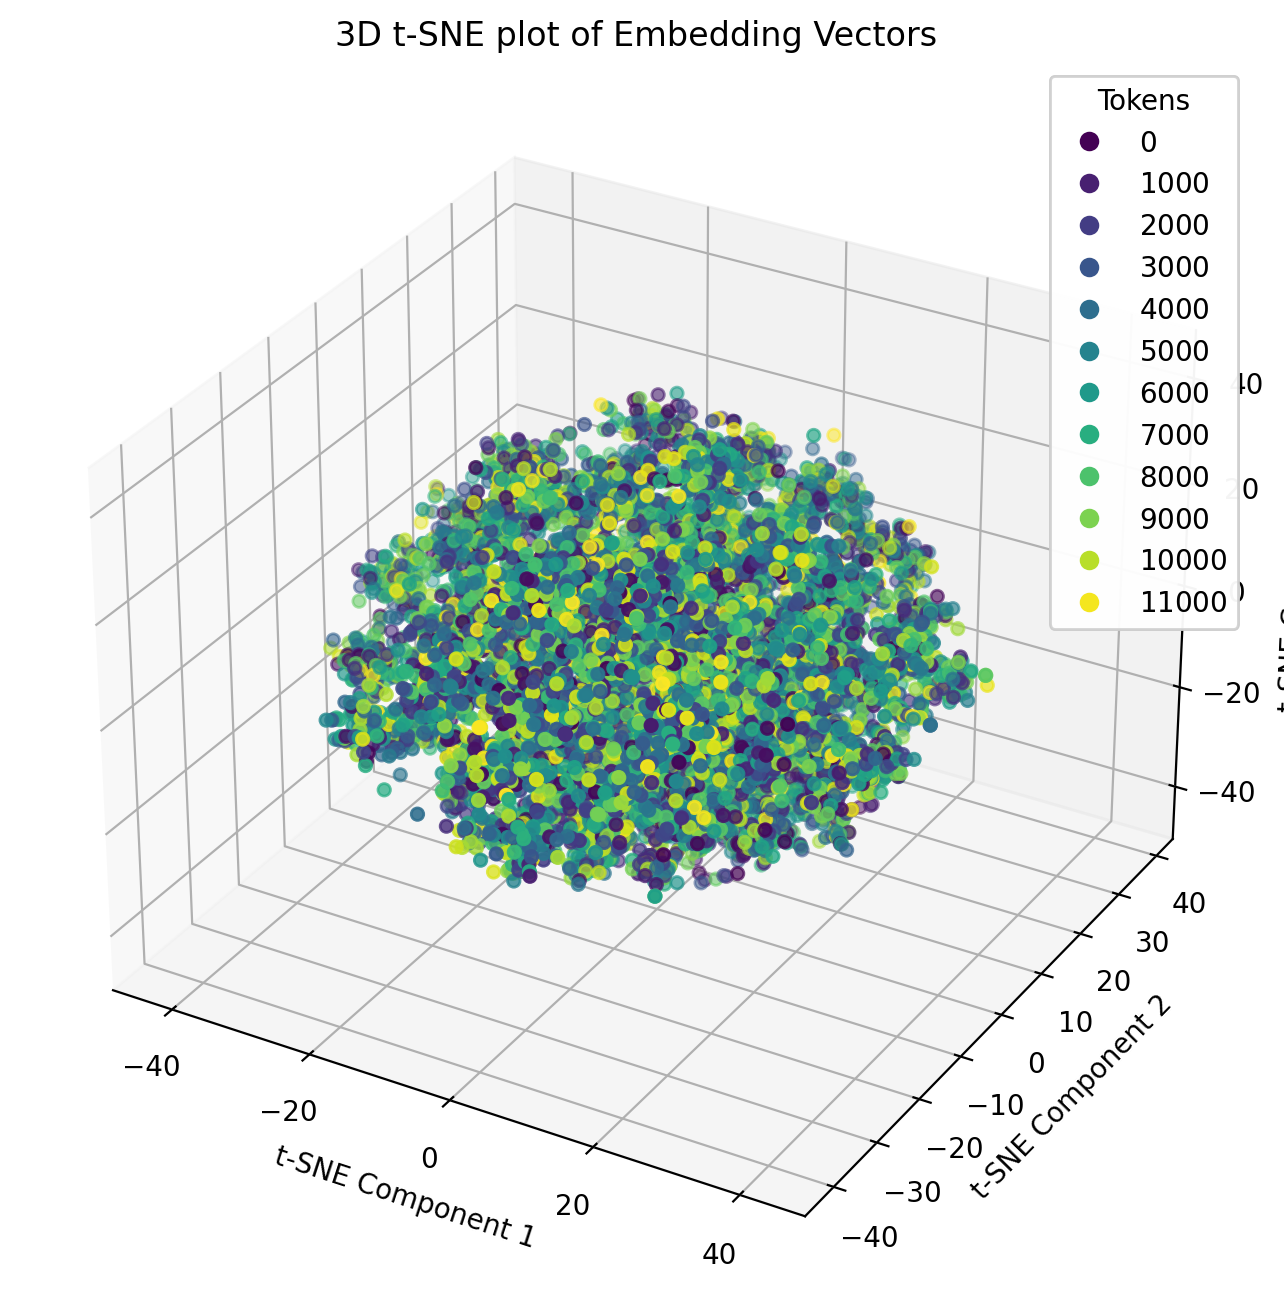

In [18]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=50, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [19]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_64_1024.pth")

In [20]:
model = model.to(device)